# Loading Data & Descriptive Analysis

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv("review_train.csv")

In [3]:
test_df = pd.read_csv("review_test.csv")

In [4]:
train_df.columns.difference(test_df.columns)

Index([], dtype='object')

In [5]:
train_df.shape

(14825, 3)

In [6]:
test_df.shape

(3707, 3)

In [7]:
train_df["Source"] = "train"
test_df["Source"] = "test"

In [8]:
train_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [9]:
test_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [10]:
df = pd.concat([train_df, test_df])

In [11]:
df.shape

(18532, 4)

In [12]:
df.head()

,Text,Score,Sentiment,Source
0,"I got a free sample of these once, and now--we...",5,1,train
1,I used to get this Tea when I lived in Washing...,4,1,train
2,This is my all time favorite 'grab and go' sna...,5,1,train
3,This flavor is very good and unexpected. The ...,4,1,train
4,thrilled to have this assortment as i got the ...,4,1,train


In [13]:
df.tail()

,Text,Score,Sentiment,Source
3702,I always have Powerade in the house - for ever...,5,1,test
3703,I tried this coffee on a half dozen quests thi...,5,1,test
3704,The Neccos were exactly what I expected and fr...,5,1,test
3705,I thought I was doing the right thing by getti...,1,0,test
3706,Cugino's chicken noodle soup is pretty tasty. ...,5,1,test


In [82]:
df.describe()

,Score,Sentiment
count,18532.000000,18532.000000
mean,4.277304,0.843784
std,1.319827,0.363070
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


# EDA

In [14]:
df.Score.value_counts()

5    12795
4     2842
1     1866
2     1029
Name: Score, dtype: int64

In [15]:
df.Sentiment.value_counts()

1    15637
0     2895
Name: Sentiment, dtype: int64

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Score,18532.0,4.277304,1.319827,1.0,4.0,5.0,5.0,5.0
Sentiment,18532.0,0.843784,0.363070,0.0,1.0,1.0,1.0,1.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 0 to 3706
Data columns (total 4 columns):
Text         18532 non-null object
Score        18532 non-null int64
Sentiment    18532 non-null int64
Source       18532 non-null object
dtypes: int64(2), object(2)
memory usage: 723.9+ KB


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import seaborn as sns

In [75]:
# plt.figure(figsize=(5,5))
# plt.title("Overall comparision between Positive and Negative sentiments")
# sns.barplot(x=df.Sentiment, y=df['Score'])
# plt.ylabel("Score)")

Text(0.5, 1.0, 'Scores Distribution')

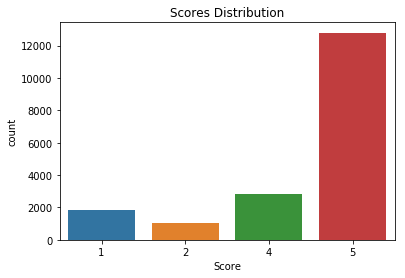

In [76]:
sns.countplot(x='Score', data=df)
plt.title("Scores Distribution")
# sns.barplot(x = df.Score.value_counts().index, y = df.Score.value_counts())

Text(0.5, 1.0, 'Sentiment Distribution')

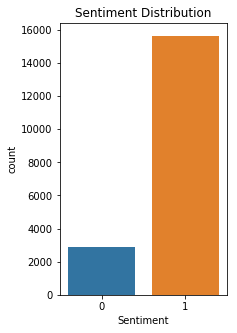

In [77]:
plt.figure(figsize=(3,5))
sns.countplot(x='Sentiment', data=df)
plt.title("Sentiment Distribution")

In [80]:
plt.figure(figsize=(5,3))
corr = df.corr()
print(corr)

              Score  Sentiment
Score      1.000000   0.952582
Sentiment  0.952582   1.000000


<Figure size 360x216 with 0 Axes>

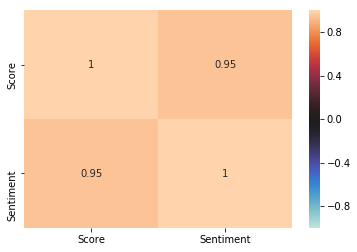

In [81]:
ax = sns.heatmap(corr,vmin=-1,vmax=1,center=0,annot=True)

# Data Preprocessing